## plotFluxes_TVan_CLM
#### Plots simulated vs. observed ratiation, energy fluxes & GPP at tower sites
- Obs here are flux tower data, included in met forcing data
- Created by Will Wieder, Sept 20, 2020

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
from scipy import signal,stats
import cftime
import nc_time_axis
import dask
#import cf_units as cf

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from distributed import wait

%matplotlib inline

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='10GB')
cluster.scale(1)

In [4]:
cluster

### Point to files

In [29]:
# Niwot LTER  simulations
site  = ['mm']
longSite  =  'moist meadow'#'dry_meadow'
rollHour = -12  
case  = ['NEON_NIWO_anom','NEON_NIWO_NOanom'] #['clm50bgc_NWT_'+site[s] for s in range(len(site))]
years   = [2020]
nmon  = 12
#OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/'+longSite+'/'
#OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
#OUTdir = OBSdir
#print(OBSfile)


CLMdir = ['/glade/scratch/wwieder/archive/'+case[c]+'/lnd/hist/' for c in range(len(case))]

#CLMtrans = [CLMdir[0] + case[0] +'.clm2.h1.'+str(years_T[i]) +'-01-01-00000.nc' \
#           for i in range(len(years_T)) ]  
#CLManom = [CLMdir[1] + case[1] +'.clm2.h1.'+str(years_A[i]) +'-01-01-00000.nc' \
#           for i in range(len(years_A)) ]  
#CLMfile = CLMtrans+CLManom
CLMfile = [CLMdir[c] + case[c] +'.clm2.h1.'+str(years[0]) +'-01-01-00000.nc' \
           for c in range(len(case)) ] 
CLMfile

['/glade/scratch/wwieder/archive/NEON_NIWO_anom/lnd/hist/NEON_NIWO_anom.clm2.h1.2020-01-01-00000.nc',
 '/glade/scratch/wwieder/archive/NEON_NIWO_NOanom/lnd/hist/NEON_NIWO_NOanom.clm2.h1.2020-01-01-00000.nc']

### Read in dataset 
- get rid of extra dimensions
- remove CLM time shift

In [30]:
%%time
dsAnom = utils.time_set_mid(xr.open_dataset(CLMfile[0], decode_times=True), 'time').persist()
_ = wait(dsAnom)
dsNoAnom = utils.time_set_mid(xr.open_dataset(CLMfile[1], decode_times=True), 'time').persist()
_ = wait(dsNoAnom)
print('---- read  in data  ----')

---- read  in data  ----
CPU times: user 1.61 s, sys: 38.7 ms, total: 1.65 s
Wall time: 1.74 s


In [82]:
TASanomFile = '/glade/p/cgd/tss/people/oleson/anomaly_forcing/af.tas.CESM.SSP370.2015-2100.nc'
TASanom = xr.open_dataset(TASanomFile, decode_times=True)
PRanomFile = '/glade/p/cgd/tss/people/oleson/anomaly_forcing/af.pr.CESM.SSP370.2015-2100.nc'
PRanom = xr.open_dataset(PRanomFile, decode_times=True)
HUSSanomFile = '/glade/p/cgd/tss/people/oleson/anomaly_forcing/af.huss.CESM.SSP370.2015-2100.nc'
HUSSanom = xr.open_dataset(HUSSanomFile, decode_times=True)
FLDSanomFile = '/glade/p/cgd/tss/people/oleson/anomaly_forcing/af.rlds.CESM.SSP370.2015-2100.nc'
FLDSanom = xr.open_dataset(FLDSanomFile, decode_times=True)
FSDSanomFile = '/glade/p/cgd/tss/people/oleson/anomaly_forcing/af.rsds.CESM.SSP370.2015-2100.nc'
FSDSanom = xr.open_dataset(FSDSanomFile, decode_times=True)

plat, plon = 40.05236, 254.41676
TASanom = TASanom.tas.isel(time=slice(59,73)).sel(lat=plat,lon=plon,method='nearest')
PRanom = PRanom.pr.isel(time=slice(59,73)).sel(lat=plat,lon=plon,method='nearest')
HUSSanom = HUSSanom.huss.isel(time=slice(59,73)).sel(lat=plat,lon=plon,method='nearest')
FLDSanom = FLDSanom.rlds.isel(time=slice(59,73)).sel(lat=plat,lon=plon,method='nearest')
FSDSanom = FSDSanom.rsds.isel(time=slice(59,73)).sel(lat=plat,lon=plon,method='nearest')

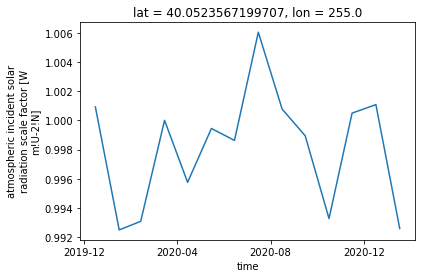

In [83]:
FSDSanom.plot()

In [33]:
# get rid of extra dimensions & coordinates 
dsNoAnom = dsNoAnom.isel(lndgrid=0)
dsNoAnom = dsNoAnom.shift(time=-1)
dsAnom  = dsAnom.isel(lndgrid=0)
dsAnom = dsAnom.shift(time=-1)

Text(0.5, 1.0, 'TBOT')

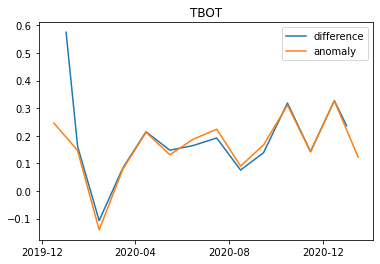

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone


In [106]:
diff = dsAnom.copy(deep=True) 
diff['TBOT'] = diff.TBOT - dsNoAnom.TBOT
diff['PR'] = (diff.RAIN+diff.SNOW) - (dsNoAnom.RAIN+dsNoAnom.SNOW)
diff['RH'] = diff.RH - dsNoAnom.RH
diff['FLDS'] = diff.FLDS - dsNoAnom.FLDS
diff['FSDS'] = diff.FSDS - dsNoAnom.FSDS

plt.plot(diff['TBOT'].time, diff['TBOT'])
plt.plot(TASanom.time, TASanom) ;
plt.legend(['difference','anomaly'])
plt.title('TBOT')


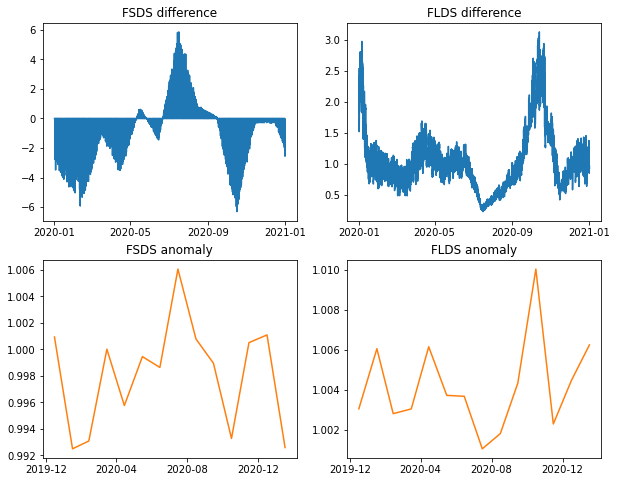

In [102]:
# Shortwave radiation
plt.figure(figsize=[10,8])
plt.subplot(2,2,1)
plt.plot(diff['FSDS'].time, diff['FSDS'])
plt.title('FSDS difference')
plt.subplot(2,2,3)
plt.title('FSDS anomaly')
plt.plot(FSDSanom.time, FSDSanom,c='tab:orange') ;

# Longwave radtiation
plt.subplot(2,2,2)
plt.plot(diff['FLDS'].time, diff['FLDS'])
plt.title('FLDS difference')
plt.subplot(2,2,4)
plt.title('FLDS anomaly')
plt.plot(FLDSanom.time, FLDSanom,c='tab:orange') ;

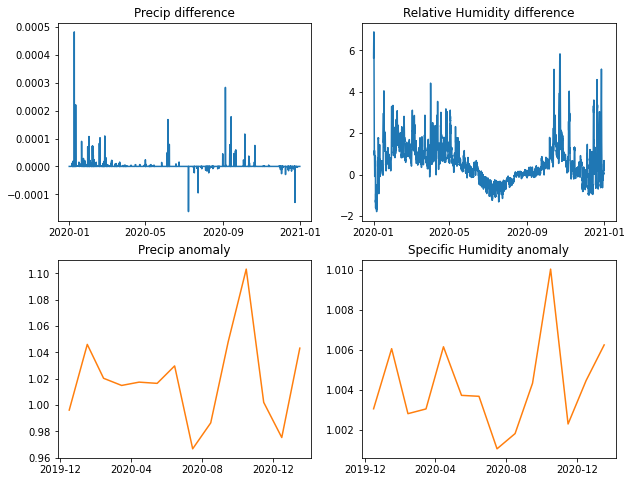

In [101]:
# Precip
plt.figure(figsize=[10,8])
plt.subplot(2,2,1)
plt.plot(diff['PR'].time, diff['PR'])
plt.title('Precip difference')
plt.subplot(2,2,3)
plt.title('Precip anomaly')
plt.plot(PRanom.time, PRanom,c='tab:orange') ;

# relative vs. specific humidity...?
plt.subplot(2,2,2)
plt.plot(diff['RH'].time, diff['RH'])
plt.title('Relative Humidity difference')
plt.subplot(2,2,4)
plt.title('Specific Humidity anomaly')
plt.plot(HUSSanom.time, FLDSanom,c='tab:orange') ;

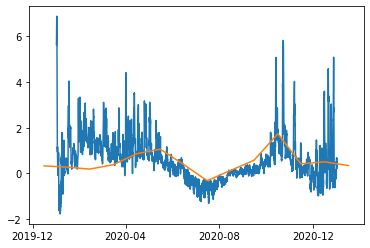

In [100]:
plt.plot(diff['RH'].time, diff['RH'])
plt.plot(HUSSanom.time, HUSSanom*1e4) ;

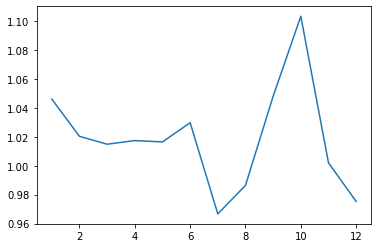

In [55]:
# Pressure, no history output... just plot anomalies
moPR = diff['PR'].groupby('time.month').sum()
moPR
#plt.plot(moPR.month, moPR)
plt.plot(PRanom.isel(time=slice(1,-1))['time.month'], PRanom.isel(time=slice(1,-1)));